# Part 2: Multiclass Classification

Based on the undersampled dataset prepared in the previous notebook, we will develop a multiclass classification model to predict whether a cassava crop is healthy or to identify the specific type of disease affecting the crop.

### Import Libraries

In [39]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import PIL
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
from collections import Counter
from torchinfo import summary
from training import train, predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


### Exploring and Preparing the Data

In [42]:
data_dir = "../data/plant disease/Cassava/undersampled"
classes = os.listdir(data_dir)
classes

['Cassava bacterial blight',
 'Cassava brown spot',
 'Cassava green mite',
 'Cassava healthy',
 'Cassava mosaic']

In [4]:
dataset = datasets.ImageFolder(data_dir)

set([dataset[i][0].mode for i in range(len(dataset))])

{'RGB'}

In [5]:
set([dataset[i][0].size for i in range(len(dataset))])

{(400, 400)}

In [6]:
type(dataset[0][0]), type(dataset[0][1])

(PIL.Image.Image, int)

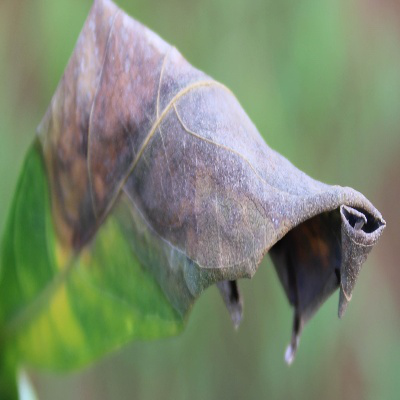

In [7]:
dataset[0][0]

In [8]:
dataset[0][1]

0

From the above cells, images have 'RGB' mode (meaning we don't need to convert images), size of the images is (400, 400) of which we need to make change them to (224, 224), and finally we need to convert the images to tensors to work on the dataset.

In [9]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

In [10]:
dataset = datasets.ImageFolder(data_dir, transform)
print(type(dataset))
print(len(dataset))

<class 'torchvision.datasets.folder.ImageFolder'>
5075


In [11]:
dataset[0]

(tensor([[[0.5569, 0.5490, 0.5490,  ..., 0.5804, 0.5765, 0.5804],
          [0.5608, 0.5569, 0.5529,  ..., 0.5765, 0.5765, 0.5765],
          [0.5608, 0.5608, 0.5608,  ..., 0.5843, 0.5843, 0.5804],
          ...,
          [0.1529, 0.1569, 0.1569,  ..., 0.4549, 0.4471, 0.4471],
          [0.1451, 0.1451, 0.1529,  ..., 0.4510, 0.4471, 0.4471],
          [0.1333, 0.1373, 0.1373,  ..., 0.4471, 0.4431, 0.4431]],
 
         [[0.5216, 0.5176, 0.5216,  ..., 0.4863, 0.4824, 0.4863],
          [0.5255, 0.5255, 0.5255,  ..., 0.4902, 0.4824, 0.4824],
          [0.5294, 0.5333, 0.5333,  ..., 0.4980, 0.4902, 0.4863],
          ...,
          [0.2824, 0.2863, 0.2902,  ..., 0.5843, 0.5843, 0.5843],
          [0.2784, 0.2745, 0.2824,  ..., 0.5882, 0.5843, 0.5843],
          [0.2745, 0.2706, 0.2667,  ..., 0.5843, 0.5804, 0.5804]],
 
         [[0.4078, 0.4039, 0.4078,  ..., 0.4392, 0.4353, 0.4392],
          [0.4118, 0.4118, 0.4118,  ..., 0.4431, 0.4353, 0.4353],
          [0.4157, 0.4196, 0.4196,  ...,

In [12]:
dataset[0][0].shape

torch.Size([3, 224, 224])

From the shape of the first element of the dataset, which indicates values in tensor of the first converted image, $3$ is number of channels (RGB), the two $224$ are width and height of the image after it was resized.

Now, the image data is converted to Tensor. Let's check the mean and standard deviation.

In [13]:
chnl_means, chnl_sq_means = 0, 0
for data, _ in tqdm(dataset, desc= "Computing mean and std:"):
    chnl_means += torch.mean(data, dim= [1, 2])
    chnl_sq_means += torch.mean(data ** 2, dim= [1, 2])

mean = chnl_means / len(dataset)
std = (chnl_sq_means / len(dataset) - mean ** 2) ** 0.5

Computing mean and std::   0%|          | 0/5075 [00:00<?, ?it/s]

In [14]:
print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: tensor([0.4776, 0.5616, 0.4120])
Standard deviation: tensor([0.2078, 0.1952, 0.2577])


Based on the mean and std values, update the transformation pipeline.

In [15]:
norm_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean= mean, std= std)
    ]
)

In [16]:
norm_dataset = datasets.ImageFolder(data_dir, norm_transform)
chnl_means, chnl_sq_means = 0, 0
for data, _ in tqdm(norm_dataset, desc= "Computing mean and std:"):
    chnl_means += torch.mean(data, dim= [1, 2])
    chnl_sq_means += torch.mean(data ** 2, dim= [1, 2])

norm_mean = chnl_means / len(norm_dataset)
norm_std = (chnl_sq_means / len(norm_dataset) - norm_mean ** 2) ** 0.5
print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Computing mean and std::   0%|          | 0/5075 [00:00<?, ?it/s]

Mean: tensor([4.2786e-08, 4.8600e-06, 9.1988e-07])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])


In [17]:
len(norm_dataset)

5075

### Train-Validation Splitting

Now the dataset is normalized and ready for training. For the purpose of checking the performance of the developed model, let's devide the dataset into training and validation sets.

In [18]:
# for reproducibility of predictions
g = torch.Generator()
g.manual_seed(42)

train_set, val_set = random_split(norm_dataset, [0.8, 0.2], generator= g)

print("Lengrh of training set:", len(train_set))
print("Lengrh of validation set:", len(val_set))

Lengrh of training set: 4060
Lengrh of validation set: 1015


In [19]:
train_percent = np.round(len(train_set) * 100 / len(norm_dataset), 2)
print("Training set percentage:", train_percent, "%")

Training set percentage: 80.0 %


  0%|          | 0/5075 [00:00<?, ?it/s]

Cassava bacterial blight    1015
Cassava brown spot          1015
Cassava green mite          1015
Cassava healthy             1015
Cassava mosaic              1015
dtype: int64


<Axes: >

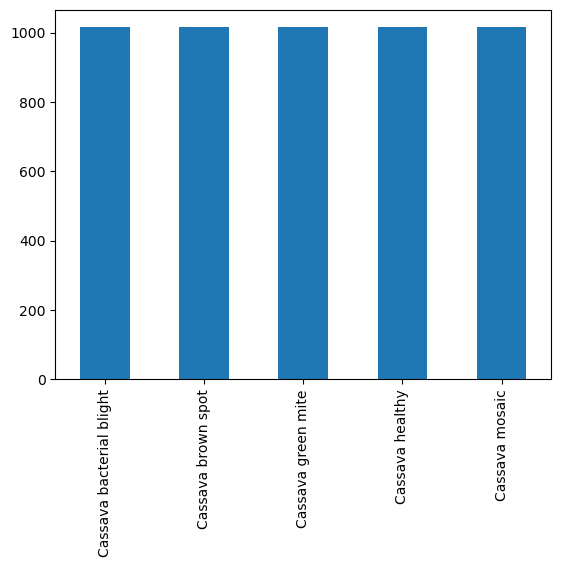

In [43]:
class_counts = Counter(x[1] for x in tqdm(norm_dataset))
class_to_idx = norm_dataset.class_to_idx

data_classes = pd.Series({cat: class_counts[idx] for cat, idx in class_to_idx.items()})
print(data_classes)
data_classes.plot(kind= "bar")

  0%|          | 0/4060 [00:00<?, ?it/s]

Cassava bacterial blight    803
Cassava brown spot          811
Cassava green mite          826
Cassava healthy             818
Cassava mosaic              802
dtype: int64


<Axes: >

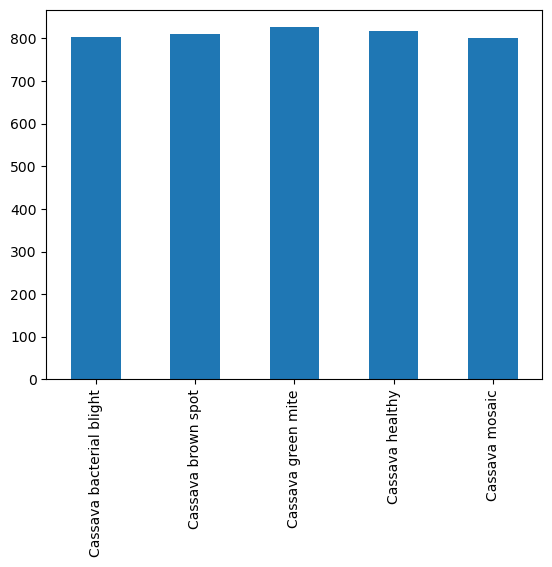

In [21]:
class_counts = Counter(x[1] for x in tqdm(train_set))
class_to_idx = norm_dataset.class_to_idx

train_classes = pd.Series({cat: class_counts[idx] for cat, idx in class_to_idx.items()})
print(train_classes)
train_classes.plot(kind= "bar")

  0%|          | 0/1015 [00:00<?, ?it/s]

Cassava bacterial blight    212
Cassava brown spot          204
Cassava green mite          189
Cassava healthy             197
Cassava mosaic              213
dtype: int64


<Axes: >

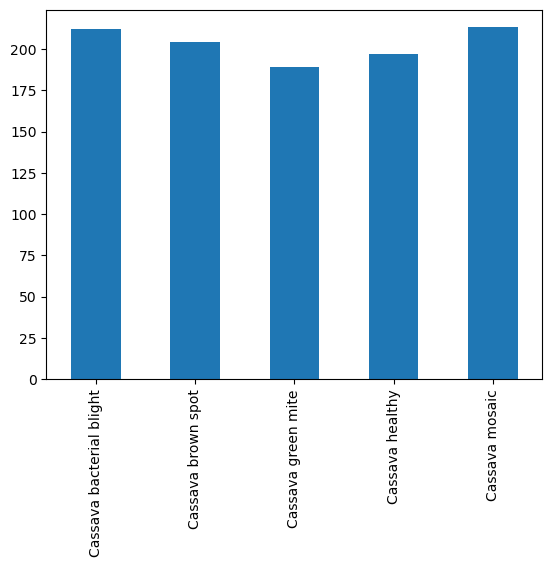

In [22]:
class_counts = Counter(x[1] for x in tqdm(val_set))
class_to_idx = norm_dataset.class_to_idx

val_classes = pd.Series({cat: class_counts[idx] for cat, idx in class_to_idx.items()})
print(val_classes)
val_classes.plot(kind= "bar")

As can be seen above, the dataset is equally distributed among the classes, whereas the training and validation sets are roughly uniformlly distributed.

It's time to create DataLoader objects for training and validation sets.

In [23]:
train_loader = DataLoader(train_set, batch_size= 32, shuffle= True)
val_loader = DataLoader(val_set, batch_size= 32)

This creates a data divided into batches of tensors and targets (labels). One batch of images has 32 images data in tensor. Check the dimension of one batch.

In [24]:
sample_data = iter(train_loader)

img, labels = next(sample_data)

print("Shape of one batch of images:", img.shape)
print("Shape of one batch of labels:", labels.shape)

Shape of one batch of images: torch.Size([32, 3, 224, 224])
Shape of one batch of labels: torch.Size([32])


### Building a Convolutional Neural Network

In [25]:
model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels= 3, out_channels= 16, kernel_size= 3, padding= 1)
model.append(conv1)
model.append(torch.nn.ReLU())
max_pool1 = torch.nn.MaxPool2d(kernel_size= 2, stride= 2)
model.append(max_pool1)

conv2 = torch.nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= 3, padding= 1)
model.append(conv2)
model.append(torch.nn.ReLU())
max_pool2 = torch.nn.MaxPool2d(2, 2)
model.append(max_pool2)

conv3 = torch.nn.Conv2d(32, 64, 3, padding= 1)
model.append(conv3)
model.append(torch.nn.ReLU())
max_pool3 = torch.nn.MaxPool2d(2, 2)
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout(p= 0.5))

lin1 = torch.nn.Linear(in_features= 64 * 28 * 28, out_features= 500)
model.append(lin1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout(0.5))

out_layer = torch.nn.Linear(in_features= 500, out_features= len(classes))
model.append(out_layer)

summary(model, input_size= [32, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 5]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500

In [26]:
model.to(device= device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=5, bias=True)
)

### Training the Model

First, let's define loss function and optimizer that will be used in the training.

In [27]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [28]:
train_losses, val_losses, train_accuracies, val_accuracies = train(model, optimizer, loss_fn, train_loader, val_loader, epochs= 15)

Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.21
    Training accuracy: 0.49
    Validation loss: 1.24
    Validation accuracy: 0.46


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 0.92
    Training accuracy: 0.66
    Validation loss: 0.99
    Validation accuracy: 0.58


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.82
    Training accuracy: 0.69
    Validation loss: 0.95
    Validation accuracy: 0.61


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.64
    Training accuracy: 0.76
    Validation loss: 0.83
    Validation accuracy: 0.67


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.43
    Training accuracy: 0.86
    Validation loss: 0.70
    Validation accuracy: 0.72


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.32
    Training accuracy: 0.90
    Validation loss: 0.71
    Validation accuracy: 0.74


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.23
    Training accuracy: 0.93
    Validation loss: 0.73
    Validation accuracy: 0.73


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.18
    Training accuracy: 0.94
    Validation loss: 0.86
    Validation accuracy: 0.73


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.09
    Training accuracy: 0.98
    Validation loss: 0.74
    Validation accuracy: 0.76


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.07
    Training accuracy: 0.98
    Validation loss: 0.74
    Validation accuracy: 0.75


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 11
    Training loss: 0.03
    Training accuracy: 0.99
    Validation loss: 0.72
    Validation accuracy: 0.78


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 12
    Training loss: 0.02
    Training accuracy: 1.00
    Validation loss: 0.86
    Validation accuracy: 0.76


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 13
    Training loss: 0.02
    Training accuracy: 1.00
    Validation loss: 0.97
    Validation accuracy: 0.75


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 14
    Training loss: 0.02
    Training accuracy: 1.00
    Validation loss: 0.89
    Validation accuracy: 0.78


Training:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/127 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 15
    Training loss: 0.12
    Training accuracy: 0.97
    Validation loss: 1.25
    Validation accuracy: 0.73


Let's save the model for future tasks, as training the model takes lots of time.

In [36]:
torch.save(model, os.path.join('../model/project_2', 'first_model'))

In [44]:
model = torch.load("../model/project_2/first_model")
model

C:\Users\IYUEL\AppData\Local\Temp\ipykernel_8644\2683370110.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("../model/project_2/first_model")


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=5, bias=True)
)

In [33]:
model_training_result = pd.DataFrame(
    {
        "Training accuracies": train_accuracies,
        "Training losses": train_losses,
        "Validation accuracies": val_accuracies,
        "Validation losses": val_losses
    }
)
model_training_result

,Training accuracies,Training losses,Validation accuracies,Validation losses
0,0.487697,1.206135,0.456055,1.242690
1,0.655266,0.922018,0.581055,0.989551
2,0.688484,0.818174,0.613281,0.953815
3,0.759843,0.641231,0.666016,0.827406
4,0.864173,0.425512,0.720703,0.699364
5,0.901083,0.321739,0.735352,0.712803
6,0.932333,0.227573,0.729492,0.731951
7,0.939469,0.179985,0.730469,0.856836
8,0.979823,0.085382,0.760742,0.742689
9,0.984498,0.069026,0.753906,0.738410


In [47]:
model_training_result.to_csv("part_2_model_training_result.csv")

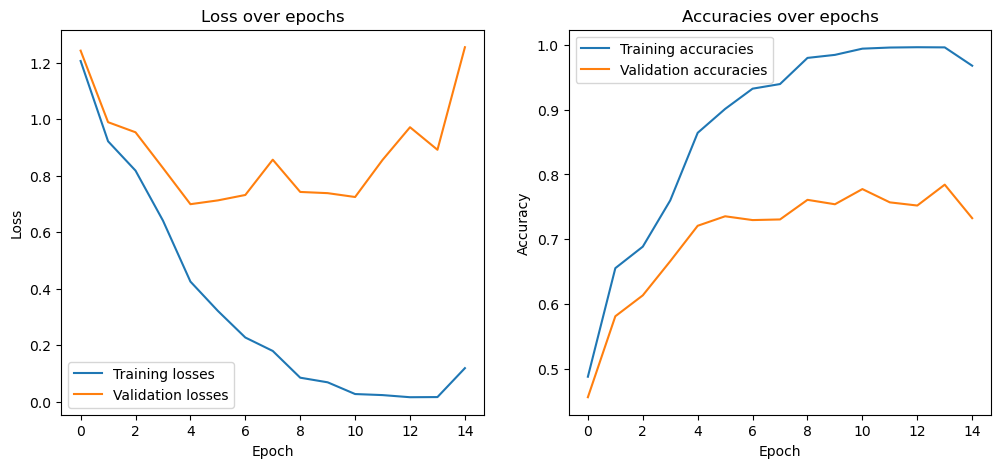

In [34]:
plt.figure(figsize= (12, 5))

plt.subplot(1, 2, 1)
plt.plot(model_training_result["Training losses"], label= "Training losses")
plt.plot(model_training_result["Validation losses"], label= "Validation losses")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_training_result["Training accuracies"], label= "Training accuracies")
plt.plot(model_training_result["Validation accuracies"], label= "Validation accuracies")
plt.title("Accuracies over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

From the above figures, it can be seen that as training progresses, the training accuracy improves with decreasing training loss. However, the validation accuracy indicates that the model performs poorly on the validation set as the loss on validation set starts to increases after fourth epoch. This is a sign of `overfitting`.

For this nootebook, let's leave it as it is. For now compute the confusion matrix for our model using validation data.

First let's use *predict* function to get the prediction probabilities of the model on the validation data. Then we will get the true labels of the validation data. Finally, confusion matrix will be generated.

In [37]:
probs_val = predict(model, val_loader, device= device)
preds_val = torch.argmax(probs_val, dim= 1)
print(preds_val)

Predicting:   0%|          | 0/32 [00:00<?, ?it/s]

tensor([4, 3, 1,  ..., 0, 4, 1])


In [38]:
targs_val = torch.cat([labels for _, labels in val_loader]).to(device)
targs_val

tensor([4, 4, 1,  ..., 0, 4, 1])

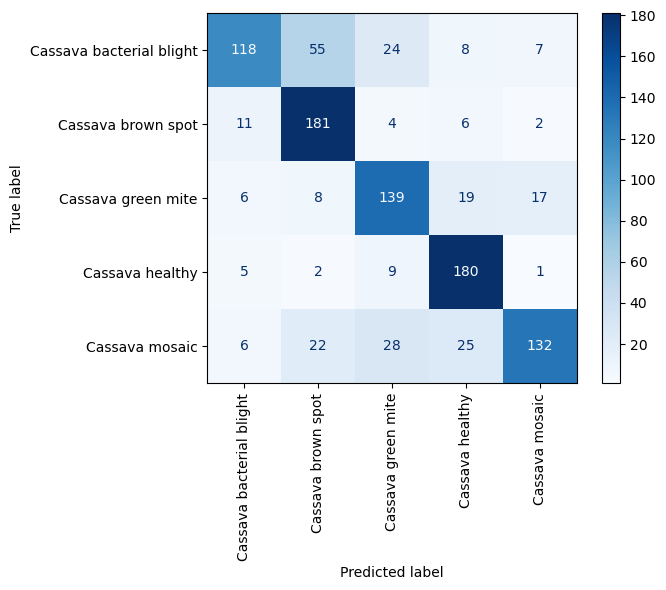

In [45]:
cm = confusion_matrix(targs_val.cpu(), preds_val.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= classes)
disp.plot(cmap= plt.cm.Blues, xticks_rotation= "vertical")
plt.show()

### Conclusion

In this notebook, A CNN model is developed and trained for predicting whether the crop is healthy or not and if it not healthy, what is the type of crop disease.

Evenif the model training takes long time, the resulting model becomes overfitting. In the next notebook, we will try to make improvements on the overfit.